In [ ]:
from multiprocessing import Pool
from functools import partial
import bilby
import numpy as np
import scipy
import lal
import lalsimulation as lalsim
from matplotlib import pyplot as plt

%matplotlib inline


def normalising(hf, psd_array, delta_f):
    return hf / np.sqrt(
        bilby.gw.utils.noise_weighted_inner_product(hf, hf, psd_array, 1 / delta_f).real
    )


def mismatch(h1_norm, h2_norm, psd_array, delta_f):
    return (
        1
        - bilby.gw.utils.noise_weighted_inner_product(
            h1_norm, h2_norm, psd_array, 1 / delta_f
        ).real
    )


def mismatch_with_time_phase_shift(
    time_phase_shift, freq, delta_f, psd_array, h1_norm, h2_norm
):
    shift = 1j * (2 * np.pi * freq * time_phase_shift[0] + time_phase_shift[1])
    h1_norm_shifted = h1_norm * np.exp(shift)
    return mismatch(h1_norm_shifted, h2_norm, psd_array, delta_f)

sh: 1: source: not found


ModuleNotFoundError: No module named 'lal'

In [2]:
parameters = {
    "total_mass": 43.95150288,
    "mass_ratio": 0.4960166,
    "chi_1": -0.31793288,
    "chi_2": -0.23096549,
    "phase": 0.0,
    "theta_jn": np.pi / 2,
    "luminosity_distance": 800.0,
}
parameters = bilby.gw.conversion.generate_mass_parameters(parameters)
print(parameters)

duration = 16.0
sampling_frequency = 4096
start_time = 0.0

appro_1 = "NRHybSur3dq8"
appro_2 = "IMRPhenomXAS"

wf_args_1 = dict(
    reference_frequency=20.0,
    minimum_frequency=20.0,
    maximum_frequency=2048.0,
    catch_waveform_errors=True,
    waveform_approximant=appro_1,
    mode_array=[[2, 2]],
)

wf_args_2 = dict(
    reference_frequency=20.0,
    minimum_frequency=20.0,
    maximum_frequency=2048.0,
    catch_waveform_errors=True,
    waveform_approximant=appro_2,
    mode_array=[[2, 2]],
)

{'total_mass': 43.95150288, 'mass_ratio': 0.4960166, 'chi_1': -0.31793288, 'chi_2': -0.23096549, 'phase': 0.0, 'theta_jn': 1.5707963267948966, 'luminosity_distance': 800.0, 'mass_1': 29.37902084776332, 'mass_2': 14.57248203223668, 'chirp_mass': 17.797039385845075, 'symmetric_mass_ratio': 0.2216273665282954}


15:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


{'reference_frequency': 20.0, 'minimum_frequency': 20.0, 'maximum_frequency': 2048.0, 'catch_waveform_errors': True, 'waveform_approximant': 'IMRPhenomXAS', 'mode_array': [[2, 2]]}


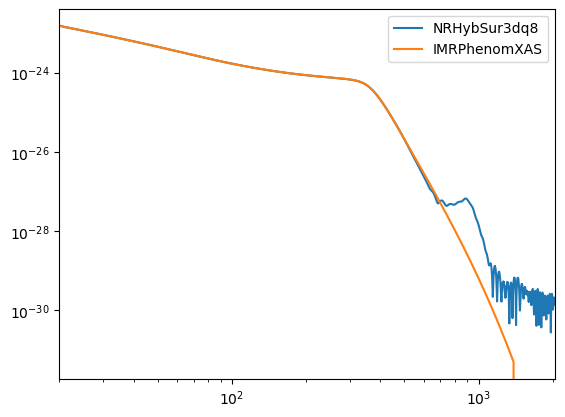

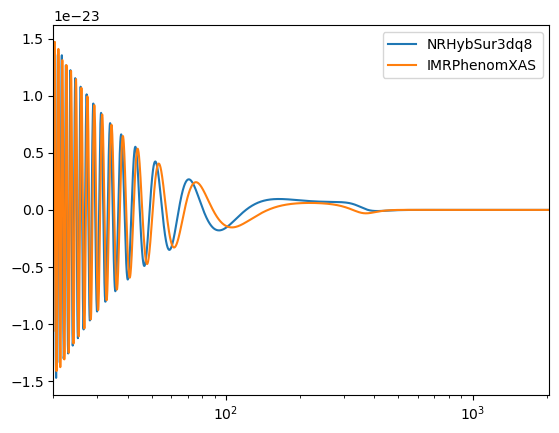

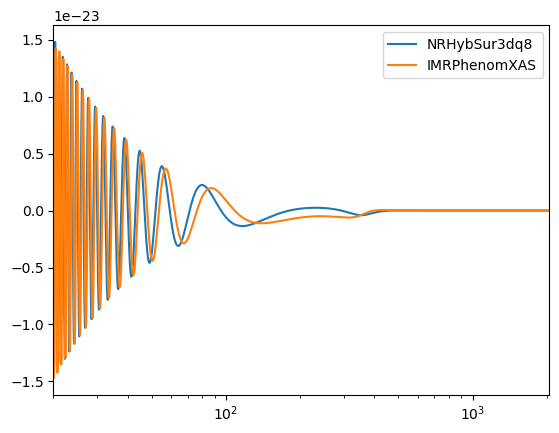

In [ ]:
wf_1 = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    start_time=start_time,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=wf_args_1,
)

wf_2 = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    start_time=start_time,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=wf_args_2,
)

hf_1 = wf_1.frequency_domain_strain(parameters)
hf_2 = wf_2.frequency_domain_strain(parameters)
freq = wf_1.frequency_array
freq_mask = (freq >= wf_args_1["minimum_frequency"]) * (
    freq <= wf_args_1["maximum_frequency"]
)

fig, ax = plt.subplots()
ax.loglog(freq[freq_mask], np.abs(hf_1["plus"])[freq_mask], label=appro_1)
ax.loglog(freq[freq_mask], np.abs(hf_2["plus"])[freq_mask], label=appro_2)
ax.set_xlim(wf_args_1["minimum_frequency"], wf_args_1["maximum_frequency"])
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.semilogx(freq[freq_mask], hf_1["plus"][freq_mask].real, label=appro_1)
ax.semilogx(freq[freq_mask], hf_2["plus"][freq_mask].real, label=appro_2)
ax.set_xlim(wf_args_1["minimum_frequency"], wf_args_1["maximum_frequency"])
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.semilogx(freq[freq_mask], hf_1["plus"][freq_mask].imag, label=appro_1)
ax.semilogx(freq[freq_mask], hf_2["plus"][freq_mask].imag, label=appro_2)
ax.set_xlim(wf_args_1["minimum_frequency"], wf_args_1["maximum_frequency"])
ax.legend()
fig.show()

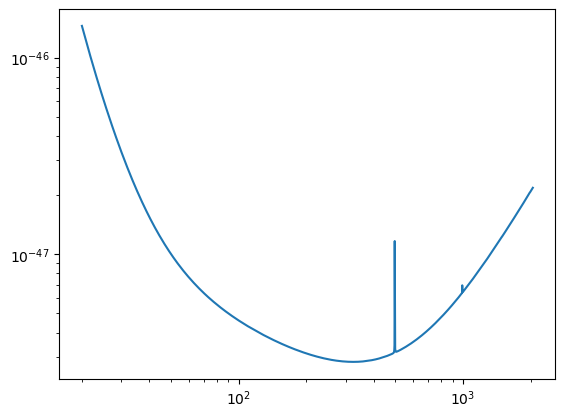

In [4]:
PSD_Aplus = bilby.gw.detector.PowerSpectralDensity(asd_file="AplusDesign.txt")
# PSD_Aplus = bilby.gw.detector.PowerSpectralDensity(asd_file="aligo_O4high.txt")
psd_array = PSD_Aplus.get_power_spectral_density_array(freq[freq_mask])

fig, ax = plt.subplots()
ax.loglog(freq[freq_mask], psd_array)
fig.show()

In [5]:
delta_f = freq[1] - freq[0]
h1_norm = normalising(hf_1["plus"][freq_mask], psd_array, delta_f)
h2_norm = normalising(hf_2["plus"][freq_mask], psd_array, delta_f)

minimizing_res = scipy.optimize.dual_annealing(
    mismatch_with_time_phase_shift,
    bounds=((-0.1, 0.1), (-np.pi, np.pi)),
    args=(freq[freq_mask], delta_f, psd_array, h1_norm, h2_norm),
)
print(minimizing_res)

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 0.00010416153890346891
       x: [-1.277e-04 -8.240e-01]
     nit: 1000
    nfev: 4154
    njev: 51
    nhev: 0


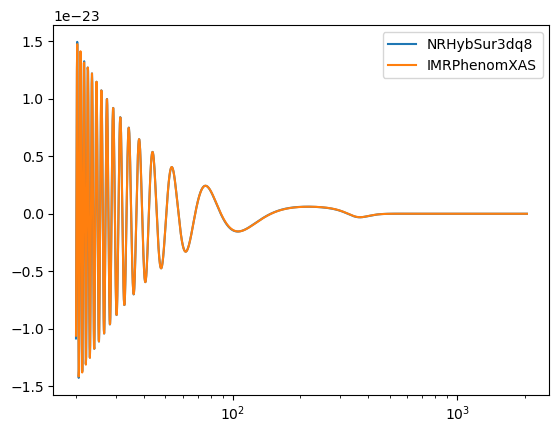

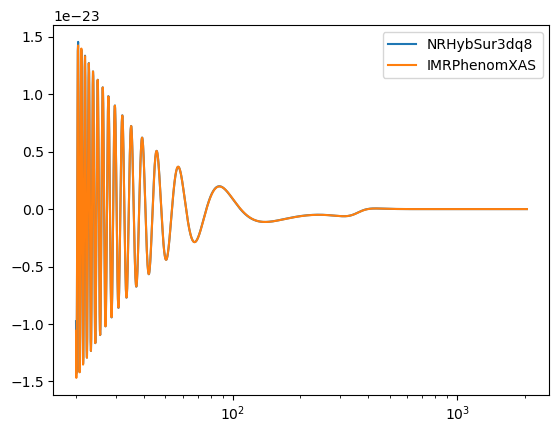

In [6]:
t_shift = minimizing_res.x[0]
phi_shift = minimizing_res.x[1]

fig, ax = plt.subplots()
ax.semilogx(
    freq[freq_mask],
    (
        hf_1["plus"][freq_mask]
        * np.exp(1j * (2 * np.pi * freq[freq_mask] * t_shift + phi_shift))
    ).real,
    label=appro_1,
)
ax.semilogx(freq[freq_mask], hf_2["plus"][freq_mask].real, label=appro_2)
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.semilogx(
    freq[freq_mask],
    (
        hf_1["plus"][freq_mask]
        * np.exp(1j * (2 * np.pi * freq[freq_mask] * t_shift + phi_shift))
    ).imag,
    label=appro_1,
)
ax.semilogx(freq[freq_mask], hf_2["plus"][freq_mask].imag, label=appro_2)
ax.legend()
fig.show()

In [ ]:
appro_nrhyb = "NRHybSur3dq8"
appro_xas = "IMRPhenomXAS"
appro_d = "IMRPhenomD"

duration = 16.0
sampling_frequency = 4096.0
start_time = 0.0
reference_frequency = 20.0
minimum_frequency = 20.0
maximum_frequency = 2048.0

wf_args_nrhyb = dict(
    reference_frequency=reference_frequency,
    minimum_frequency=minimum_frequency,
    maximum_frequency=maximum_frequency,
    waveform_approximant=appro_nrhyb,
    mode_array=[[2, 2]],
)
wf_args_xas = dict(
    reference_frequency=reference_frequency,
    minimum_frequency=minimum_frequency,
    maximum_frequency=maximum_frequency,
    waveform_approximant=appro_xas,
    mode_array=[[2, 2]],
)
wf_args_d = dict(
    reference_frequency=reference_frequency,
    minimum_frequency=minimum_frequency,
    maximum_frequency=maximum_frequency,
    waveform_approximant=appro_d,
    mode_array=[[2, 2]],
)
wf_nrhyb = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    start_time=start_time,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=wf_args_nrhyb,
)
wf_xas = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    start_time=start_time,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=wf_args_xas,
)
wf_d = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    start_time=start_time,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=wf_args_d,
)

freq = wf_nrhyb.frequency_array
freq_mask = freq_mask = (freq >= wf_args_nrhyb["minimum_frequency"]) * (
    freq <= wf_args_nrhyb["maximum_frequency"]
)
delta_f = freq[1] - freq[0]

PSD_Aplus = bilby.gw.detector.PowerSpectralDensity(asd_file="AplusDesign.txt")
psd_array = PSD_Aplus.get_power_spectral_density_array(freq[freq_mask])


def minimized_mismatch(total_mass, mass_ratio, chi_1, chi_2, wf_gen_1, wf_gen_2):
    params = {
        "total_mass": total_mass,
        "mass_ratio": mass_ratio,
        "chi_1": chi_1,
        "chi_2": chi_2,
        "phase": 0.0,
        "theta_jn": np.pi / 2,
        "luminosity_distance": 800.0,
    }
    h1 = wf_gen_1.frequency_domain_strain(params)["plus"][freq_mask]
    h2 = wf_gen_2.frequency_domain_strain(params)["plus"][freq_mask]
    h1_norm = normalising(h1, psd_array, delta_f)
    h2_norm = normalising(h2, psd_array, delta_f)

    minimizing_res = scipy.optimize.dual_annealing(
        mismatch_with_time_phase_shift,
        bounds=((-0.1, 0.1), (-np.pi, np.pi)),
        args=(freq[freq_mask], delta_f, psd_array, h1_norm, h2_norm),
    )
    if minimizing_res.success:
        return minimizing_res.fun
    else:
        raise ValueError("minimizing func exited fail")

16:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
16:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [6]:
num = 1000
parameters = {}
rng = np.random.default_rng(seed=20241031)
parameters["total_mass"] = rng.uniform(20, 250, num)
parameters["mass_ratio"] = rng.uniform(0.125, 1.0, num)
parameters["chi_1"] = rng.uniform(-0.8, 0.8, num)
parameters["chi_2"] = rng.uniform(-0.8, 0.8, num)
params_array = np.vstack(
    [
        parameters["total_mass"],
        parameters["mass_ratio"],
        parameters["chi_1"],
        parameters["chi_2"],
    ]
).T

nproc = 72
with Pool(processes=nproc) as pool:
    mism = np.array(pool.starmap(minimized_mismatch, params_array))
parameters[f"mismatch_{appro_1}_{appro_2}"] = mism
print(parameters)

{'total_mass': array([ 32.68947116, 102.63555375,  61.77869476, 130.39652306,
       157.29491624, 209.79684063, 163.54475501, 160.64294753,
       157.53721465, 195.18893409, 152.30291817,  40.55080366,
       175.07792744, 226.63876119, 208.31213769, 145.00822147,
       236.77869511, 186.09751998,  94.98437156, 176.17483554,
       152.73284406,  37.04786095, 124.95077786,  42.42512929,
       210.47970541, 180.5096393 , 193.48871819,  38.3857659 ,
       107.61598718, 165.77736018, 166.70693848, 189.98043218,
       152.90829096,  79.53743935,  94.8094129 , 169.22015064,
       153.05025877, 193.39599576, 197.477794  ,  65.48364772,
       246.5017478 , 106.20612224,  66.12229587, 107.7193905 ,
       128.86004483,  31.46257657,  23.79741042, 225.9768461 ,
       170.7368849 , 131.11663815,  95.84363735,  94.11981101,
       148.77200616,  72.66799486, 234.3203529 , 102.9516484 ,
       181.93518395, 224.27733036, 221.42311787, 210.48602583,
        93.51753658, 209.22374186, 152.0

[( 32.68947116, 0.80763915, -0.24581593,  0.35499357, 4.85499735e-04)
 (102.63555375, 0.73788087, -0.00869258,  0.1530393 , 4.03329325e-04)
 ( 61.77869476, 0.35222616, -0.19681646, -0.47894411, 4.88472619e-04)
 (130.39652306, 0.28210073, -0.11567404,  0.2729483 , 1.50755817e-03)
 (157.29491624, 0.40517451,  0.16374834, -0.4982512 , 2.19066999e-04)
 (209.79684063, 0.75044071,  0.52897081, -0.27127258, 5.80132291e-04)
 (163.54475501, 0.97006147,  0.66749955,  0.72024019, 3.77465524e-04)
 (160.64294753, 0.7350061 , -0.36307795, -0.52243589, 1.71975255e-04)
 (157.53721465, 0.69977944,  0.41542325,  0.55594974, 2.55077700e-04)
 (195.18893409, 0.74329329, -0.60890227, -0.10135817, 1.92188266e-04)
 (152.30291817, 0.32657097, -0.73972602, -0.20525826, 5.60373087e-04)
 ( 40.55080366, 0.21217096,  0.73330487, -0.62608527, 4.46874762e-02)
 (175.07792744, 0.49421213,  0.79946529, -0.39066152, 2.62917021e-03)
 (226.63876119, 0.43468452, -0.70900177, -0.24929374, 3.62584022e-04)
 (208.31213769, 0.53

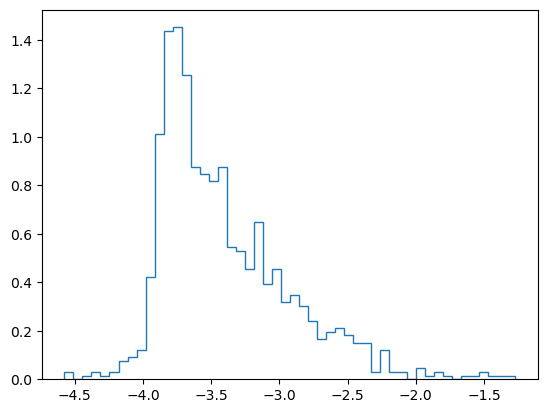

In [7]:
param_keys = list(parameters.keys())
structed_params = np.array(
    list(zip(*[parameters[key] for key in param_keys])),
    dtype=[(key, "float") for key in param_keys],
)
np.save(f"mismatch_{appro_1}_{appro_2}", structed_params)
print(structed_params)

fig, ax = plt.subplots()
ax.hist(
    np.log10(parameters[f"mismatch_{appro_1}_{appro_2}"]),
    density=True,
    bins=50,
    histtype="step",
    label=f"{appro_1}_{appro_2}",
)
fig.show()